# Testing Notebook

The goal of this notebook is to test the code, so that changes if changes are made it can be checked whether the new code is equivalent to the old code. For that, certain parameters must be kept the same. 
For redundancy, here is another specification of the parameters:
- The data folder is called testing, all files should be loaded from this folder and never be overwritten.
- The critical radius for all searching procedures is 15 
- The random seed, given at the initiation should be 0


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt#
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import csv
import pickle

%matplotlib inline

## Utils

### General and Read-In

In [2]:
def read_in_flat(fn, conv2int = False):
    '''Reads in a flat list (first element of each line of the file)'''
    with open (fn, newline = '') as f:
        rr = csv.reader(f, delimiter = ' ')
        if conv2int: res = [int(float(line[0])) for line in rr]
        else: res = [float(line[0]) for line in rr]
    return res

def read_in_nested(fn, conv2int = False):
    '''Reads in a nested list where each line of the file is converted to a list itself.'''
    with open (fn, newline = '') as f:
        rr = csv.reader(f, delimiter = ' ')
        if conv2int: res = [[int(float(i)) for i in line] for line in rr]
        else:res = [[float(i) for i in line] for line in rr]
    return res

def read_in_multiple (fn_begin, fn_end, nested, conv2int = False, ind_start = 0, max_ind = 10000):
    '''Reads in data from multiple files with similar names and  concatenates them.
    Filename convention: fn_begin + str(id) + fn_end, where id is increased step by step until no more file is found.
    If nested, each line of the file will be converted to an extra list.'''
    new_file = True
    cur_id = int(ind_start)
    res = []
    while new_file and cur_id<=max_ind:
        fn_no = fn_begin + str(cur_id)+fn_end
        try: 
            if nested: subres = read_in_nested (fn_no, conv2int)
            else: subres = read_in_flat (fn_no, conv2int)
        except: break
        res.extend(subres)
        cur_id = cur_id+1
    return res

def read_in_coordfile (fn, parse_ignore = True, return_list = False):
    '''
    reads in the file stored under fn, packing each line in an array line (-> file should have the same number of elments in each line)
    Returns a np array with the data.
    If there is a problem parsing, this function will not break, however it will store it in a dict 
    If parse-ignore is set False, the number of unparsable signs as well as a set of them will be printed.
    '''
    res = []
    with open (fn, newline = '') as f:
        rr = csv.reader(f, delimiter = ' ')
        err = []
        for line in rr:
            ar = []
            for j in range(len(line)):
                try: ar.append(float(line[j]))
                except: err.append(line[j])
            res.append(np.asarray(ar))
    if len(err)> 0 and not parse_ignore: print ('Could not parse on {} instances: {}'.format(len(err), set(err)))
    if return_list: return res
    else: return np.asarray(res)

def reshape_dendcoo (dends):
    '''Reshape the 3D coordinates for the dendrite files, adding one dimension'''
    return dends.reshape((len(dends), int(len(dends[0])/3), 3))
    
def select_region (grt, cts, xr, yr, zr, cr):
    ''' Lets you find cells with defined propoerties: x,y,z-range, and with a number of connections in range cr
    (all ranges in form [min, max]), returns indices'''
    a = np.ones(len(grt))>0
    for i, (j, k) in enumerate([xr,yr,zr]):
        a = np.logical_and(a, grt[:,i]>=j)
        a = np.logical_and(a, grt[:,i]<=k)
    a = np.logical_and (a, cts>=cr[0])
    a = np.logical_and (a, cts<=cr[1])
    return np.where(a == True)[0]

### Connectivity statistics

In [42]:
# This function does take into account cells with 0 connections
def con_per_cell (ref, n_cells):
    '''Finds the occurence of each number from 0 to n_cell-1 in ref
    -> if ref contains source or target IDs, it is the number of connections for each ID'''
    cs, c_counts = np.unique(ref, return_counts = True)
    real_ccs = np.zeros(n_cells)
    for i, c in enumerate( cs):
        real_ccs[int(c-1)]
        real_ccs[int(c-1)] = c_counts[i]
    return real_ccs

def quick_stats (ccs):
    '''quick printout of a few characteristics for fast sanity checks'''
    print ('Average number of connections:', np.mean(ccs))
    print ('Standard dev:', np.std(ccs))
    print ('Range:', min(ccs), '-', max(ccs))
    
    
def con_per_cell_multifile (fn_begin, fn_end, n_cell):
    '''Like the con_per_cell method, but can deal with data distributed over several files.
    Finds the occurence of all indices from 0 to n_cell-1 in the file fn_begin
    Filename convention: fn_begin + str(id) + fn_end, where id is increased step by step until no more file is found.'''
    new_file = True
    cur_id = 0
    res = []
    while new_file:
        fn_no = fn_begin + str(cur_id)+fn_end
        try: 
            subr = np.array(read_in_flat (fn_no, True))
            subc = con_per_cell(subr, n_cell)
        except:break
        if len(res) == 0: res = subc
        else: res = res+subc
        cur_id = cur_id+1
    return res

def unique_con_per_cell (ref, ref2_gran,  idx = -1, return_conn = False):
    ''' searches in ref for all indices given in idx and returns a unique list of the corresponding indices in ref2gran.
    Intended use: ref as target, ref2_gran as source file returns all granule cell indices that connect to the Golgi cells specified in idx
    Difference to con_per_cell: Lets you choose certain indices, returns, the IDs and not just counts, does not count diplicates'''
    if type(idx) == int: idx = [idx]
    if sum(idx) < 0: idx = np.arange(n_cell)
    res = [[] for i in range(len(idx))]
    n_r = np.zeros(len(idx))
    for n,i in  enumerate(idx):
        res[n] = list(np.unique(ref2_gran[ref == i]))
        n_r[n] = len(res[n])
        if i%1000 == 0: print (i)
    return res, n_r

def unique_con_per_cell_multifile (fn1_begin, fn2_begin, fn_end, idx = -1):
    '''Like the unique_con_per_cell method, but allows for data distributed over severall files.
    Filename convention: fn_begin + str(id) + fn_end, where id is increased step by step until no more file is found.'''
    new_file = True
    cur_id = 0
    res = []
    n_r = []
    while new_file:
        fn1_no = fn1_begin + str(cur_id)+fn_end
        fn2_no = fn2_begin + str(cur_id)+fn_end
        try: 
            ref = np.array(read_in_flat (fn1_no, True))
            ref2_gr =  np.array(read_in_flat (fn2_no, True))
        except: break
            
        sres, sn_r = unique_con_per_cell(ref, ref2_gr, idx)
        if len(res) == 0: 
            res = sres.copy()
            n_r = sn_r
        else: 
            for i in range(len(res)):
                res[i].append(sres[i])
                n_r = n_r + sn_r
        cur_id = cur_id+1
    #if type(res) == int: res = [res]
    for nr in range(len(res)):
        rr = res[nr]
        rnew = []
        for c in rr:
            if type(c) == list:
                rnew.extend(c)
            else: rnew.append(c)
        res[nr] = rnew
    return res, n_r


### Plotting

In [ ]:
def label_graph (title, xlabel, ylabel):
    plt.title (title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def plot3d (ax, dat, *args, **kwargs):
    '''plots points (or a single point) in 3D.
    ax has to have 3d proj type: ax = plt.gcf().gca(projection='3d')
    '''
    if dat == []: return
    if len(dat.shape) == 1: #if single dot
        dat = np.expand_dims(dat, axis = 0)
    ax.plot(dat[:,0], dat[:,1], dat[:,2], *args, **kwargs)
    
def plot_point_count_stats (coords, counts = [1], idx = -1, D3 = True, D2 = True, setdims2D = [-1, -1, -1]):
    ''' Plots 3d or 2d projections of points, possibly color-coded:
    coords = Coordinates of the population that is to be plotted.
    counts: 1D array, same len as coords. e.g. the number of connections per cell. If set, this quantity will be color-coded.
    idx: If set, a subpopulation of coords will be plotted, the cells specified by idx.
    D3: 3D plot, 
    D2: 2D projections
    setdims2D [x,y,z]: if set to something else than -1, this will be the upper limit of the axis.
    '''
    #set counts, prepare color norm
    if len(counts) < len(coords):
        counts = np.ones(len(coords))
        norm = mpl.colors.Normalize(vmin=0, vmax=100)
    else: norm = mpl.colors.Normalize(vmin=0, vmax=max(counts))
    # get colormap
    cmap = cm.viridis
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    rgb = m.to_rgba(counts)
    #Check if idx is set, if not, use all cells
    if type(idx)=='int': 
        if idx<0 : idx = np.arange(len(counts))
    # 3D plot
    if D3:
        plt.figure(figsize = (15,12))
        ax = plt.gcf().gca(projection='3d')
        ax.scatter(coords[idx,0], coords[idx,1], coords[idx,2], depthshade = False, facecolors = rgb[idx], s  = 40)
        plt.show()
    # 2D projections
    if D2:
        plt.figure(figsize=(21,7))
        ax_n = ['x', 'y', 'z'] 
        for i, [j, k] in enumerate([[0,1], [1,2], [0,2]]):
            plt.subplot(1,3,i+1)
            plt.scatter(coords[idx,j], coords[idx,k], facecolors = rgb[idx], s  = 30)
            label_graph(ax_n[j]+'-'+ax_n[k]+' plane', ax_n[j], ax_n[k])
            if not setdims2D[j] == -1: plt.xlim([0, setdims2D[j]])
            if not setdims2D[k] == -1: plt.ylim([0, setdims2D[k]])

In [131]:
pf2, npf2= unique_con_per_cell_multifile(path_full+'PFtoGoCtarget',path_full+'PFtoGoCsource', '.dat', [12,15])

1
[[], []]


ValueError: not enough values to unpack (expected 3, got 2)

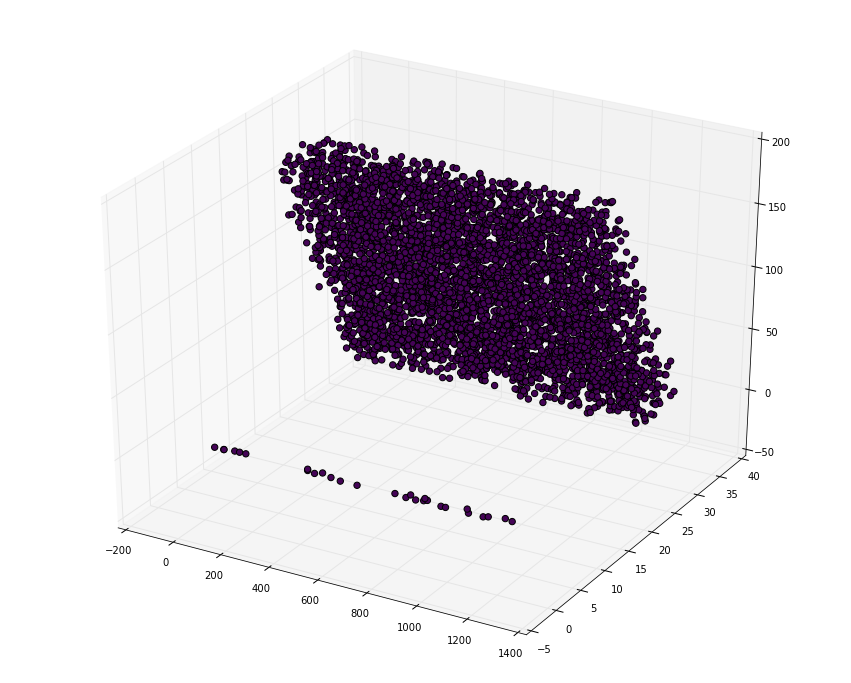

'for (i,j,k) in [[1, [-100, 1600], [-100,800]], [2,  [-100,800], [-20,220]], [3, [-100, 1600], [-20,220]]]:\n    plt.subplot(1,3,i)\n    plt.xlim(j)\n    plt.ylim(k)\nprint (gol[12])'

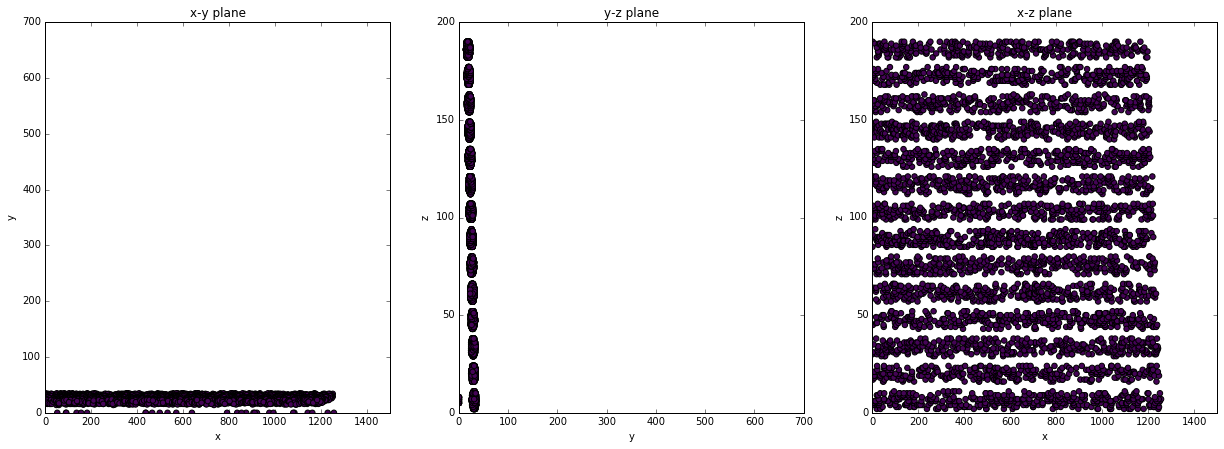

In [158]:
        
plot_point_count_stats (gran, counts = [1], idx = np.asarray(pf2[0]), D3 = True, D2 = True, setdims2D=[1500,700,200])


## Analyse the full set

### Load data

In [ ]:
path_full = 'output_pybrep/parallel_full/'

In [ ]:
#cell coordinates
gol = read_in_coordfile(path_full + 'GoCcoordinates.sorted.dat')
gran = read_in_coordfile(path_full + 'GoCcoordinates.sorted.dat')

In [78]:
#get statistics
n_gran = 798000
n_gol = 1995
so_aa = con_per_cell_multifile(path_full+'AAtoGoCsource', '.dat', n_gran)
print ('finished so_aa')
ta_aa = con_per_cell_multifile(path_full+'AAtoGoCtarget', '.dat', n_gol)
print ('finished ta_aa')
so_pf = con_per_cell_multifile(path_full+'PFtoGoCsource', '.dat', n_gran)
print ('finished so_pf')
ta_pf = con_per_cell_multifile(path_full+'PFtoGoCtarget', '.dat', n_gol)
print ('finished ta_pf')

if True:
    stat_dict = dict (so_aa = so_aa, ta_aa=ta_aa, so_pf = so_pf, ta_pf = ta_pf)
    with open (path_full+'conn_stat_dict.pkl', 'wb') as f:
        pickle.dump(stat_dict, f)

finished so_aa
finished ta_aa
finished so_pf
finished ta_pf


In [19]:
# alternatively, load already existing dict:
with open (path_full+'conn_stat_dict.pkl', 'rb') as f:
    sd = pickle.load( f)
    locals().update(sd)

### Connectivity analysis

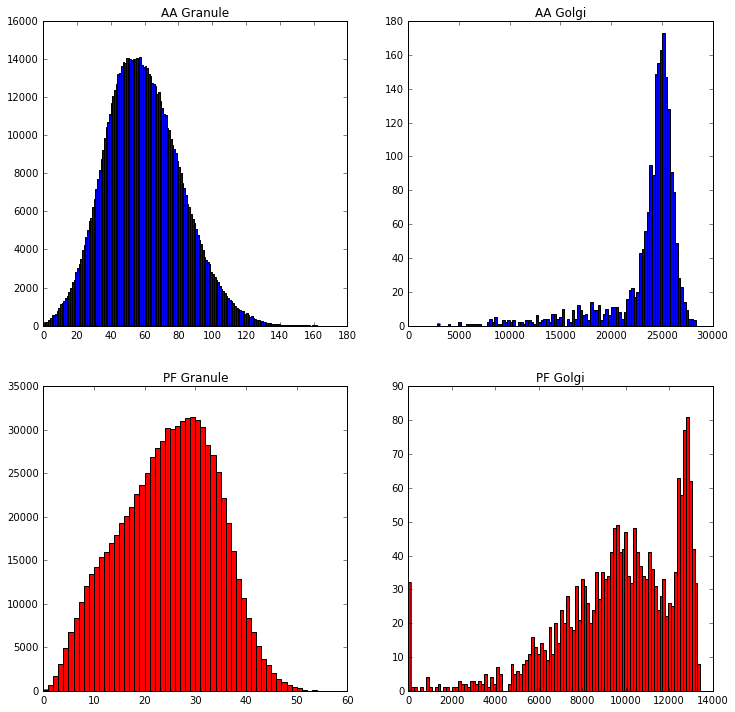

In [79]:
plt.figure(figsize = (12,12))
for n, (dat, tit) in enumerate([[so_aa, 'AA Granule (so_aa)'], [ta_aa, 'AA Golgi (ta_aa)'], [so_pf, 'PF Granule (so_pf)'], [ta_pf, 'PF Golgi (ta_pf)']]):
    plt.subplot(2,2,n+1)
    if n>1: c= 'r'# PF#
    else: c= 'b' # AA
    if n%2==1: _= plt.hist(dat,100, color = c) #Golgi
    else: _= plt.hist(dat, int(max(dat)), color = c) #Granule
    label_graph(tit, '# of connections per cell', '# of cells with x connections')
    plt.title(tit)
plt.suptitle('Connections statistics for full dataset')


### Find and investigate spatial inhomogeneities

#### Get color-coded overview over number of connections per cell

In [ ]:
plot_point_count_stats(gol, counts=ta_pf, idx = idx_all)

#### Look at interesting indices

In [ ]:
dat = ta_pf
s_val = np.sort(dat)
p10 = int(len(s_val)/10)
# 10/20% of the cells with highest/lowest number of connections
idx_top10 = dat>s_val[9*p10]
idx_bot10 = dat<s_val[p10]
idx_top20 = dat>s_val[8*p10]
idx_bot20 = dat<s_val[2*p10]

idx_upper = dat>12500 #upper peak for ta_pf hist
idx_0  = dat == 0 #cells with 0 connections

plot_point_count_stats(gol, idx = idx_top, D3 = False)
plt.suptitle('Golgi cells with 20% least connections')
plot_point_count_stats(gol, idx = idx_bot, D3 = False)
plt.suptitle('Golgi cells with 20% most connections')

#### Go more into detail: select regions with an especially high/low number of connections

In [199]:
hc_str = select_region(gol, np.asarray(ta_pf), [1200,1500], [0, 700], [100, 200], [13000, 14000])
lc_str = select_region(gol, np.asarray(ta_pf), [800,1000], [150, 550], [100, 200], [0, 10000])
plot_point_count_stats(gol, idx = hc_str, D3 = False, setdims2D=[1500,700,200])
plt.suptitle('Example for cells in region with high conn')
plot_point_count_stats(gol, idx = lc_str, D3 = False, setdims2D=[1500,700,200])
plt.suptitle('Ex')  plt.suptitle('Example for cells in region with low conn')

32
25


### Find connected granule cells for certain exemplary cells

In [ ]:
#The following test indices are examples for cells from the high/low conn region from the previous section,
# but this array can be replaced arbitrarily
test_idx = np.concatenate((on_str[:5], off_str[:5]))
pf2, npf2= unique_con_per_cell_multifile(path_full+'PFtoGoCtarget',path_full+'PFtoGoCsource', '.dat', test_idx)

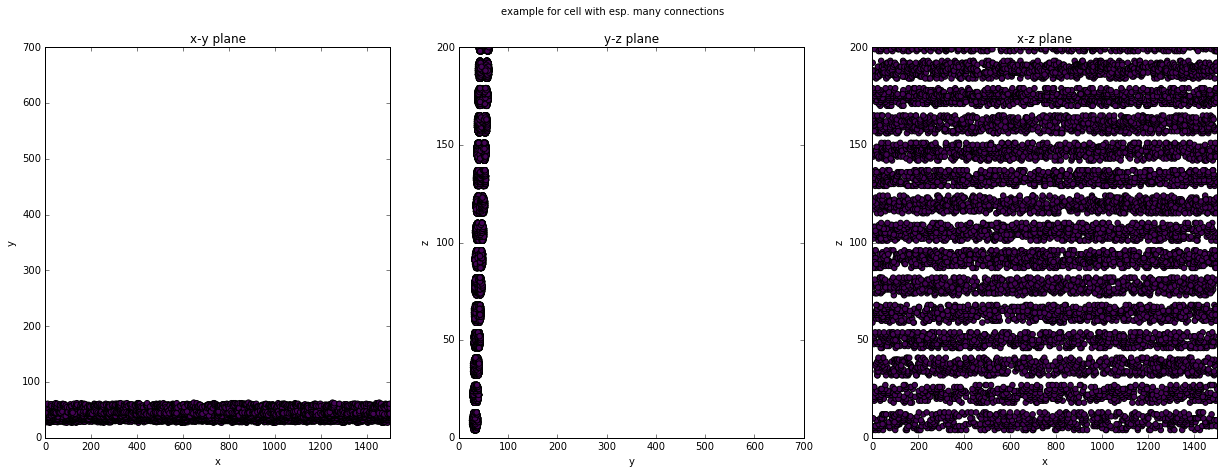

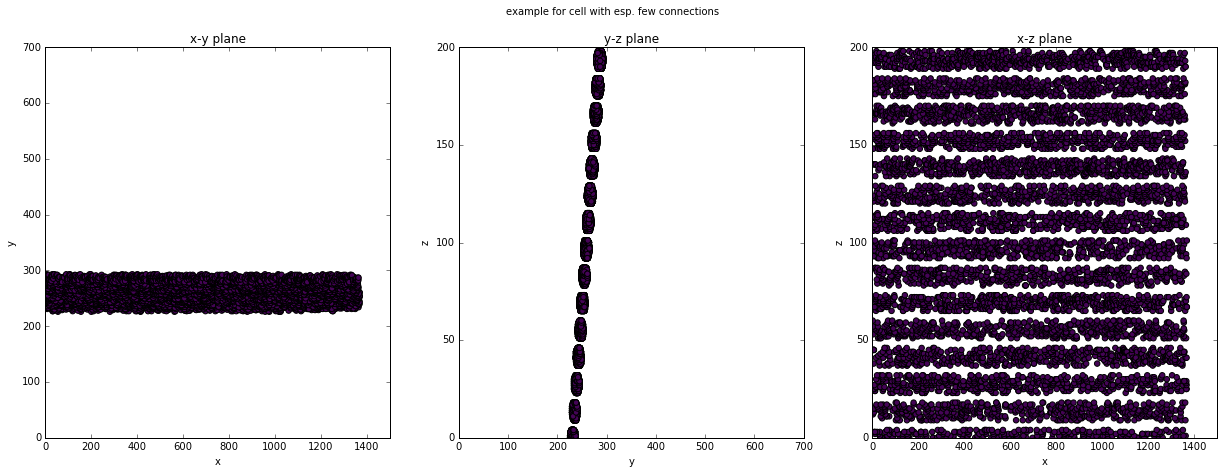

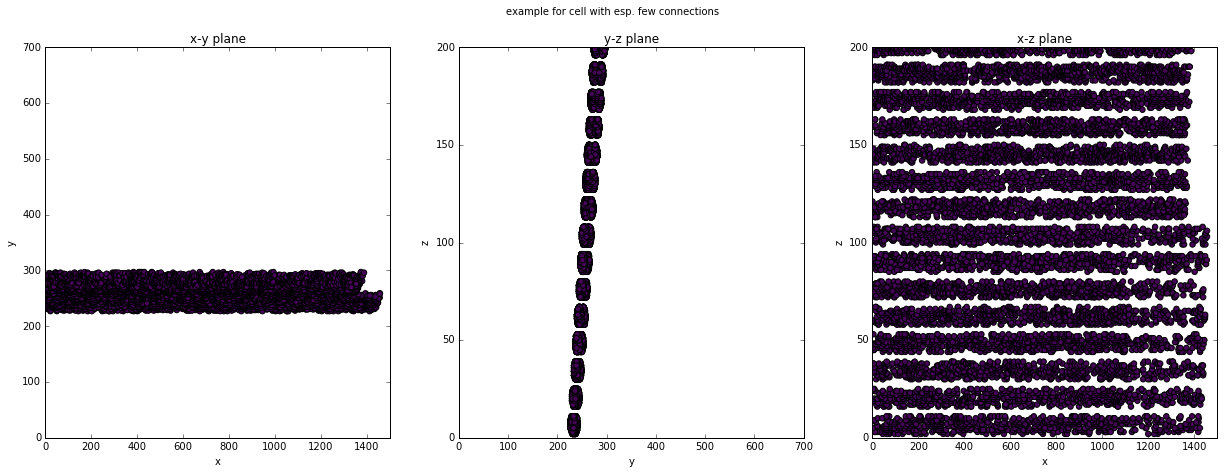

In [218]:
#plot the granule cells
plot_point_count_stats (gran, counts = [1], idx = np.asarray(pf2[0]), D3 = False, D2 = True, setdims2D=[1500,700,200])
plt.suptitle('example for cell with esp. many connections')
plot_point_count_stats (gran, counts = [1], idx = np.asarray(pf2[7]), D3 = False, D2 = True, setdims2D=[1500,700,200])
plt.suptitle('example for cell with esp. few connections')
plot_point_count_stats (gran, counts = [1], idx = np.asarray(pf2[8]), D3 = False, D2 = True, setdims2D=[1500,700,200])
plt.suptitle('example for cell with esp. few connections')

## Analyse the smaller dataset

### Read in files

In [ ]:
path = './output_pybrep/parallel_16/'

src_aa = read_in_multiple(path+'AAtoGoCsource', '.dat', False, True)
tar_aa = read_in_multiple(path+'AAtoGoCtarget', '.dat', False, True)
dis_aa = read_in_multiple(path+'AAtoGoCdistance', '.dat', False)
seg_aa = read_in_multiple(path+'AAtoGoCsegments', '.dat', True)

src_pf = read_in_multiple(path+'PFtoGoCsource', '.dat', False, True)
tar_pf = read_in_multiple(path+'PFtoGoCtarget', '.dat', False, True)
dis_pf = read_in_multiple(path+'PFtoGoCdistance', '.dat', False)
seg_pf = read_in_multiple(path+'PFtoGoCsegments', '.dat', True)

gol = read_in_coordfile(path+'GoCcoordinates.sorted.dat')
a_dend = reshape_dendcoo(read_in_coordfile(path+'GoCadendcoordinates.dat'))
b_dend = reshape_dendcoo(read_in_coordfile(path+'GoCbdendcoordinates.dat'))
gran = read_in_coordfile(path+'GCcoordinates.sorted.dat')
granT = read_in_coordfile(path+ 'GCTcoordinates.dat')

### Connectivity analysis

#### Granule cell to Golgi cell

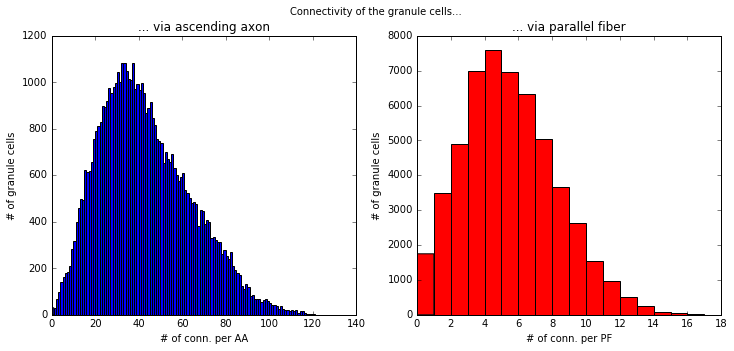

In [120]:

plt.figure(figsize = (12,5))

plt.subplot(121)

so_aa = con_per_cell(src_aa, len(gran))
_ = plt.hist(so_aa, int(max(so_aa)))
label_graph ('... via ascending axon', '# of conn. per AA', '# of granule cells')

plt.subplot(122)
so_pf = con_per_cell(src_pf, len(gran))
_ = plt.hist(so_pf, int(max(so_pf)), color = 'r')
label_graph ('... via parallel fiber', '# of conn. per PF', '# of granule cells')

plt.suptitle('Connectivity of the granule cells...')


#### Golgi cell to Granule cell

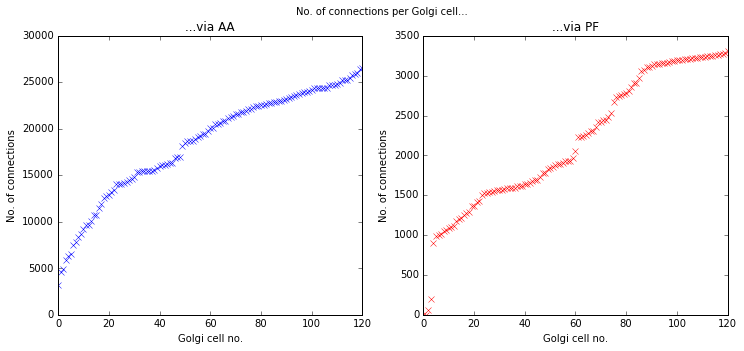

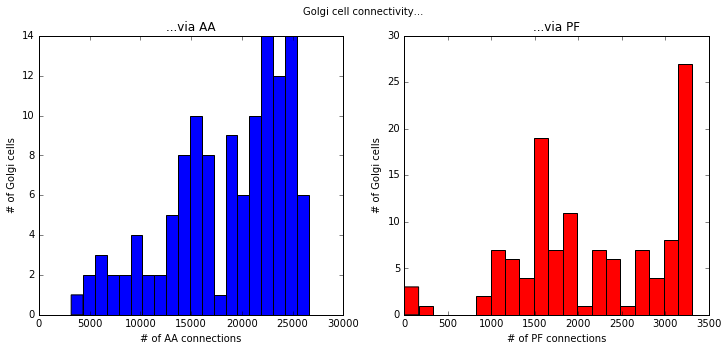

In [10]:
to_pf = con_per_cell(tar_pf, len(gol)-1)
to_aa = con_per_cell(tar_aa, len(gol)-1)
single_point_fig = True
hist_fig = True
n_bins = 20

if single_point_fig:
    plt.figure(figsize = (12,5))
    plt.subplot(121)
    plt.plot(np.sort(to_aa), 'bx')
    label_graph('...via AA', 'Golgi cell no.', 'No. of connections')
    plt.subplot(122)
    plt.plot(np.sort(to_pf), 'rx')
    label_graph('...via PF', 'Golgi cell no.', 'No. of connections')
    plt.suptitle('No. of connections per Golgi cell...')
    
if hist_fig:
    plt.figure(figsize = (12,5))
    plt.subplot(121)
    _ = plt.hist(to_aa, n_bins)
    label_graph('...via AA', '# of AA connections', '# of Golgi cells')
    plt.subplot(122)
    _ = plt.hist(to_pf,n_bins, color = 'r')
    label_graph('...via PF', '# of PF connections', '# of Golgi cells')
    plt.suptitle('Golgi cell connectivity...')

### Single cell connection visualization

#### Show all Granule cells that connect to a certain Golgi cell

/home/ines/Applications/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


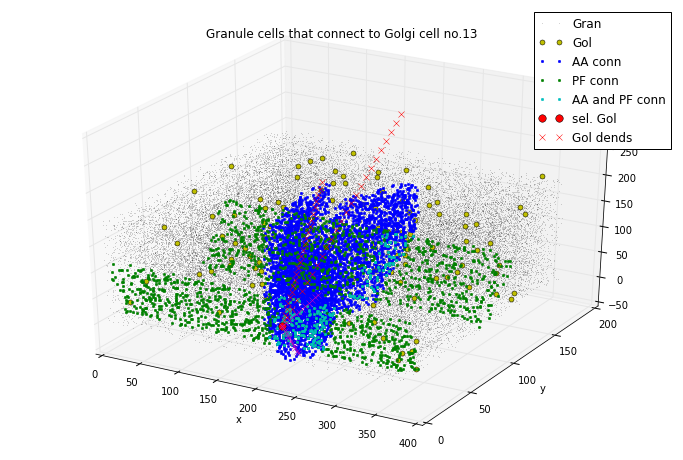

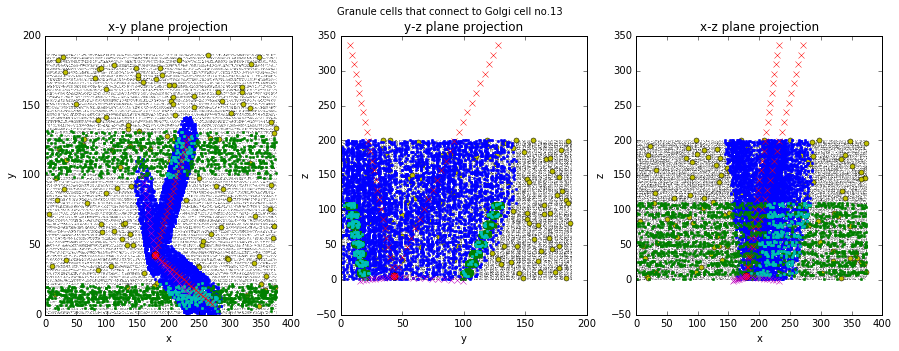

In [87]:
cell_id = 13
select_aa = True
select_pf = True
plot_dends = True

go_sel = gol[cell_id]
if select_aa: 
    idx_aa = np.unique(np.array(src_aa)[np.isclose(tar_aa, cell_id)])
    grs_aa = gran[idx_aa,:]
if select_pf: 
    idx_pf = np.unique(np.array(src_pf)[np.isclose(tar_pf, cell_id)])
    grs_pf = gran[idx_pf,:]
if select_aa and select_pf:
    idx_both = np.intersect1d(idx_pf, idx_aa)
    grs_both = gran[idx_both,:]
if plot_dends:
    ad = a_dend[cell_id]
    bd = b_dend[cell_id]
    
ms_gran = 5.0
ms_gol = 5.0


plt.figure(figsize = (12,8))
ax = plt.gcf().gca(projection='3d')
#plot ground population
plot3d(ax, gran, 'k.', markersize = 0.2, label = 'Gran')
plot3d(ax, gol, 'yo', markersize = ms_gol, label = 'Gol')
#plot selected cell and connected GrC
if select_aa: plot3d(ax, grs_aa, 'b.', markersize = ms_gran, label = 'AA conn')
if select_pf: plot3d(ax, grs_pf, 'g.', markersize = ms_gran, label = 'PF conn')
if select_aa and select_pf: plot3d(ax, grs_both,'c.', markersize = ms_gran, label = 'AA and PF conn')
plot3d(ax, go_sel, 'ro', markersize = 1.5*ms_gol, label = 'sel. Gol')
#plot dendrites
if plot_dends:
    plot3d(ax, ad, 'rx', label = 'Gol dends')
    plot3d(ax, bd, 'mx')
    
label_graph('Granule cells that connect to Golgi cell no.'+ str(cell_id), 'x', 'y')
plt.legend(loc = 0)


plt.figure(figsize=(15,5))
graph_labels = [['x-y plane projection', 'x', 'y'], ['y-z plane projection', 'y', 'z'], ['x-z plane projection', 'x', 'z']]

for i, [j, k] in enumerate([[0,1], [1,2], [0,2]]):
    plt.subplot(1,3,i+1)
    #plot ground populations
    plt.plot(gran[:,j], gran[:,k],  'k.', markersize = 0.2)
    plt.plot(gol[:,j], gol[:,k], 'yo', markersize = ms_gol)
    #plot selected cell and connected GrC
    if select_aa: plt.plot(grs_aa[:,j], grs_aa[:,k], 'b.', markersize = ms_gran)
    if select_pf: plt.plot(grs_pf[:,j], grs_pf[:,k], 'g.', markersize = ms_gran)
    if select_aa and select_pf: plt.plot(grs_both[:,j], grs_both[:,k], 'c.', markersize = ms_gran)
    plt.plot(go_sel[j], go_sel[k], 'ro', markersize = 1.5*ms_gol) 
        
    if plot_dends:
        plt.plot(ad[:,j], ad[:,k], 'rx')
        plt.plot(bd[:,j], bd[:,k], 'mx')

    label_graph(*graph_labels[i])
    
    plt.suptitle('Granule cells that connect to Golgi cell no.'+str(cell_id))
    

#### Show all Golgi cells that connect to a certain Granule cell

/home/ines/Applications/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Corresponding lengths are:  [ 633.01954403  397.90640434  264.54297645  328.65072244  634.76814763
  613.20118824  629.77075812  353.38011594  387.53784301  589.7964981
  596.692844  ]


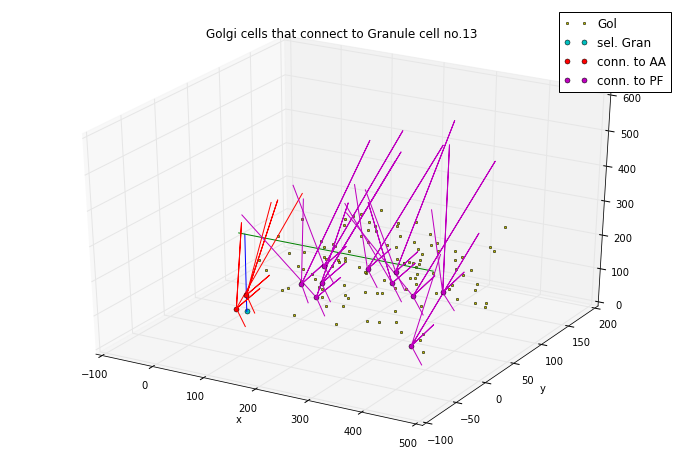

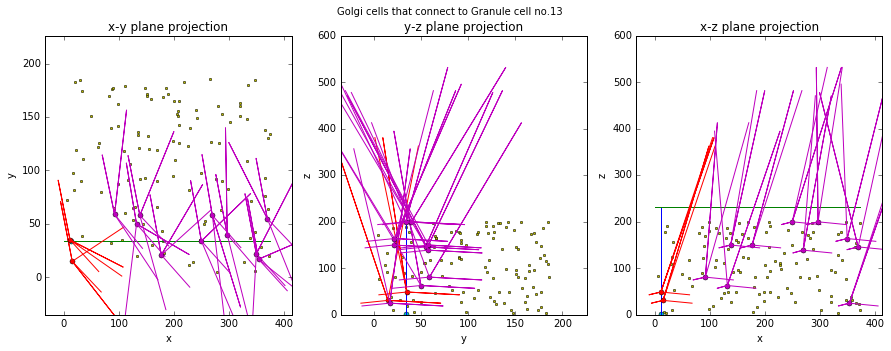

In [108]:
cell_id = 13
select_aa = True
select_pf = True
plot_dends = True

len_pf = 1000
cut_pf = True
grs = gran[cell_id,:]
aa_co = np.array([gran[cell_id,:], granT[cell_id,:]])
pf_co = np.array([granT[cell_id,:]-np.array([len_pf,0,0]),granT[cell_id,:]+np.array([len_pf, 0,0])])
if cut_pf:
    pf_co[0,0] = max ([pf_co[0,0], 0])
    pf_co[1,0] = min ([pf_co[1,0], max(gran[:, 0])]) 

if select_aa: idx_aa = np.unique(np.array(tar_aa)[np.isclose(src_aa, cell_id)])
if select_pf: idx_pf = np.unique(np.array(tar_pf)[np.isclose(src_pf, cell_id)])
    
    
ms_gran = 5.0
ms_gol = 5.0


plt.figure(figsize = (12,8))
ax = plt.gcf().gca(projection='3d')
#plot ground population, this time only Golgi...
plot3d(ax, gol, 'yo', markersize = 0.5*ms_gol, label = 'Gol')
#plot selected Granule cell
plot3d(ax, grs, 'co', markersize = ms_gran,label = 'sel. Gran')
plot3d(ax, aa_co, 'b')
plot3d(ax, pf_co, 'g')
#plot Golgi cells and Golgi cell dendrites
if select_aa: 
    first = True
    for c in idx_aa:
        if first:
            plot3d(ax, gol[c,:], 'ro', markersize = ms_gol, label = 'conn. to AA')
            first = False
        else: plot3d(ax, gol[c,:], 'ro', markersize = ms_gol)
        if plot_dends:
            plot3d (ax, a_dend[c,:], 'r')
            plot3d (ax, b_dend[c,:], 'r')
if select_pf: 
    first = True
    for c in idx_pf:
        if first:
            plot3d(ax, gol[c,:], 'mo', markersize = ms_gol, label = 'conn. to PF')
            first = False
        else: plot3d(ax, gol[c,:], 'mo', markersize = ms_gol)
        if plot_dends:
            plot3d (ax, a_dend[c,:], 'm')
            plot3d (ax, b_dend[c,:], 'm')
        

label_graph('Golgi cells that connect to Granule cell no.'+str(cell_id), 'x', 'y')
plt.legend(loc = 0)

plt.figure(figsize=(15,5))
graph_labels = [['x-y plane projection', 'x', 'y'], ['y-z plane projection', 'y', 'z'], ['x-z plane projection', 'x', 'z']]

for i, [j, k] in enumerate([[0,1], [1,2], [0,2]]):
    plt.subplot(1,3,i+1)
    plt.plot(gol[:,j], gol[:,k], 'yo', markersize = 0.5*ms_gol)
    #plot selected cell and connected GrC
    plt.plot(grs[j], grs[k], 'co', markersize = ms_gran)
    plt.plot(aa_co[:,j], aa_co[:,k], 'b')
    plt.plot(pf_co[:,j], pf_co[:,k], 'g')
    
    #plot Golgi cells and Golgi cell dendrites
    if select_aa: 
        for c in idx_aa:
            plt.plot(gol[c,j], gol[c,k],'ro', markersize = ms_gol)
            if plot_dends:
                plt.plot(a_dend[c,:,j], a_dend[c,:,k], 'r')
                plt.plot(b_dend[c,:,j], b_dend[c,:,k], 'r')
    if select_pf: 
        for c in idx_pf:
            plt.plot(gol[c,j], gol[c,k],'mo', markersize = ms_gol)
            if plot_dends:
                plt.plot(a_dend[c,:,j], a_dend[c,:,k], 'm')
                plt.plot(b_dend[c,:,j], b_dend[c,:,k], 'm')

    if True: 
        if not j == 2: plt.xlim([min(gol[:,j])-40, max(gol[:,j])+40])
        if not k == 2: plt.ylim([min(gol[:,k])-40, max(gol[:,k])+40])
    label_graph(*graph_labels[i])
    
    plt.suptitle('Golgi cells that connect to Granule cell no.'+str(cell_id))
  


### Segments and distance

#### Segments
Things to check for:
- The first column corresponds to the number of segments- is that the number you expected?
- The second column corresponds to the dendrite number.
- For AA, you would expect lower segment numbers to have a higher number of found connections, because for those segments, both basal and apical dendrites can connect, whereas for the higher segments, only basal dendrites can connect.
- For PF, you expect the dendrites 1 and 2 (the basal dendrites) to have 0 connections, because those dendrites are in the granule cell layer whereas the parallel fiber is in the molecular layer
- For PF, you would expect both high and low segment numbers to have fewer connections, because those segments are in the molecular layer only if the soma of the cell is very high or very low.

In [116]:
def con_per_seg (so):
    fc = so[:,0]
    sc = so[:,1]
    print ('First (segment number)')
    for i in np.unique(fc):
        idx = np.isclose(fc, i)
        print (i, ': n =', sum(idx))
    print ('Second (dendrite number)')
    for i in np.unique(sc):
        idx = np.isclose(sc, i)
        print (i, ': n =', sum(idx))
        
print ('AA stats:')
con_per_seg(np.array(seg_aa))
print (' ')
print ('PF stats:')
con_per_seg(np.array(seg_pf))

AA stats:
First (segment number)
1.0 : n = 685579
2.0 : n = 596709
3.0 : n = 501763
4.0 : n = 241899
5.0 : n = 222860
Second (dendrite number)
1.0 : n = 380415
2.0 : n = 414447
3.0 : n = 686883
4.0 : n = 767065
 
PF stats:
First (segment number)
1.0 : n = 7676
2.0 : n = 48143
3.0 : n = 75641
4.0 : n = 84541
5.0 : n = 47280
Second (dendrite number)
3.0 : n = 123617
4.0 : n = 139664


#### Distance

Things to check for:
- AA connections should have distances that are maximally aa_length
- PF connecions should have distances that are at least aa_length.

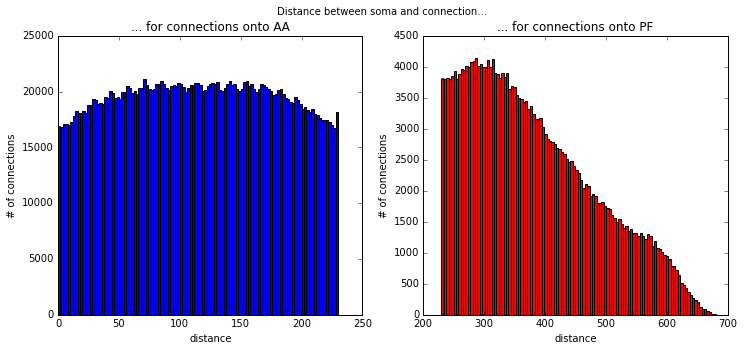

In [119]:
n_bins = 115

plt.figure(figsize = (12,5))

plt.subplot(121)
_ = plt.hist(np.array(dis_aa), n_bins)
label_graph('... for connections onto AA', 'distance', '# of connections')

plt.subplot(122)
_ = plt.hist(np.array(dis_pf),n_bins, color = 'r')
label_graph('... for connections onto PF', 'distance', '# of connections')

plt.suptitle('Distance between soma and connection...')

